In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import torch
from torch.utils.data import TensorDataset, DataLoader, Subset
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import torch.nn as nn
import torch.optim as optim
import math
from sklearn.model_selection import KFold, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load the dataset
df = pd.read_csv('DataSets/COVID-19_w_Polsce-Wzrost.csv', sep=';', usecols=['Data', 'Nowe przypadki', 'Zmiana liczby aktywnych przypadków', 'Zmiana liczby nieaktywnych przypadków', 'Nowe zgony', 'Nowe wyzdrowienia'])
df = df.dropna()

# Convert date strings to datetime objects
def convert_to_datetime_with_year_increment(date_series, start_year):
    previous_month = 0
    current_year = start_year
    datetime_list = []

    for date in date_series:
        current_month = int(date.split('/')[1])
        if current_month == 1 and previous_month == 12:
            current_year += 1
        date_with_year_str = date + f'/{current_year}'
        datetime_obj = datetime.strptime(date_with_year_str, '%d/%m/%Y')
        datetime_list.append(datetime_obj)

        previous_month = current_month

    return datetime_list

# Dla predykcji liczby nowych przypadków COVID-19, najważniejsze zmienne mogą obejmować:

# Zmiana liczby aktywnych przypadków: Może być wskaźnikiem trendu w liczbie nowych przypadków.
# Zmiana liczby nieaktywnych przypadków: Może wskazywać na przejście przypadków z aktywnych do wyzdrowiałych lub zmarłych.
# Nowe zgony: Mogą być powiązane z ciężkością sytuacji i liczbą nowych przypadków.
# Nowe wyzdrowienia: Może wpływać na liczbę aktywnych przypadków i potencjalnie na liczbę nowych przypadków.
# Liczba aktywnych przypadków: Obecna liczba aktywnych przypadków może wpływać na przyszłą liczbę nowych przypadków, sugerując wzrost lub spadek trendu.

df['Nowe przypadki'] = df['Nowe przypadki'].str.replace(' ', '').astype(int)
df['Zmiana liczby aktywnych przypadków'] = df['Zmiana liczby aktywnych przypadków'].str.replace(' ', '').astype(int)
df['Zmiana liczby nieaktywnych przypadków'] = df['Zmiana liczby nieaktywnych przypadków'].str.replace('( |-)', '', regex=True).astype(int)
df['Nowe zgony'] = df['Nowe zgony'].str.replace(' ', '').astype(int)
df['Nowe wyzdrowienia'] = df['Nowe wyzdrowienia'].str.replace('( |-)', '', regex=True).astype(int)

df['Data'] = df['Data'].apply(lambda x: "{:04.2f}".format(x).replace('.', '/'))
df['Data'] = convert_to_datetime_with_year_increment(df['Data'], 2020)


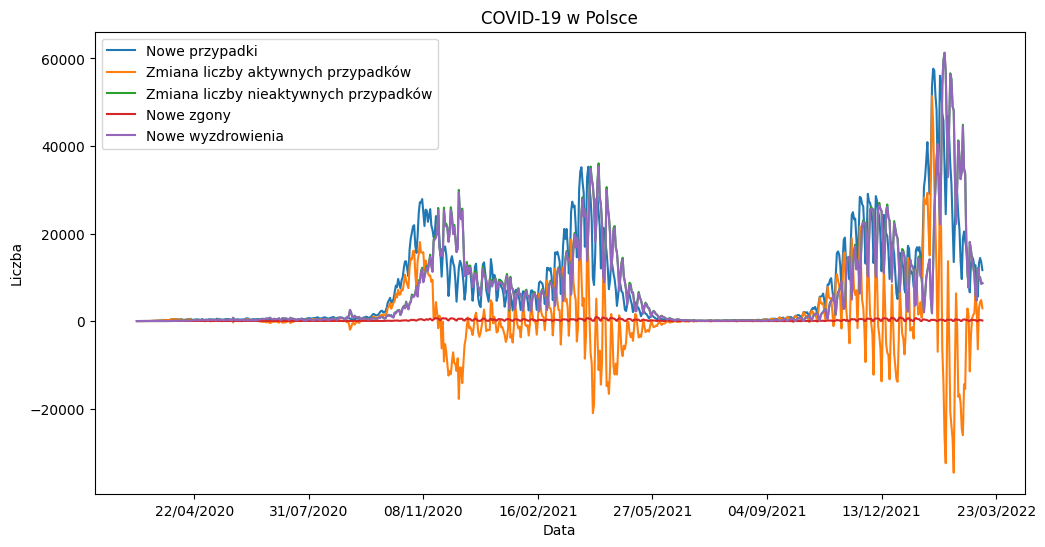

In [16]:
# Visualize the data
def visualise(df):
    plt.figure(figsize=(12, 6))
    plt.title('COVID-19 w Polsce')
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%Y'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=100))
    plt.plot(df['Data'], df['Nowe przypadki'], label='Nowe przypadki')
    plt.plot(df['Data'], df['Zmiana liczby aktywnych przypadków'], label='Zmiana liczby aktywnych przypadków')
    plt.plot(df['Data'], df['Zmiana liczby nieaktywnych przypadków'], label='Zmiana liczby nieaktywnych przypadków')
    plt.plot(df['Data'], df['Nowe zgony'], label='Nowe zgony')
    plt.plot(df['Data'], df['Nowe wyzdrowienia'], label='Nowe wyzdrowienia')
    plt.xlabel('Data')
    plt.ylabel('Liczba')
    plt.legend()
    plt.show()

visualise(df)

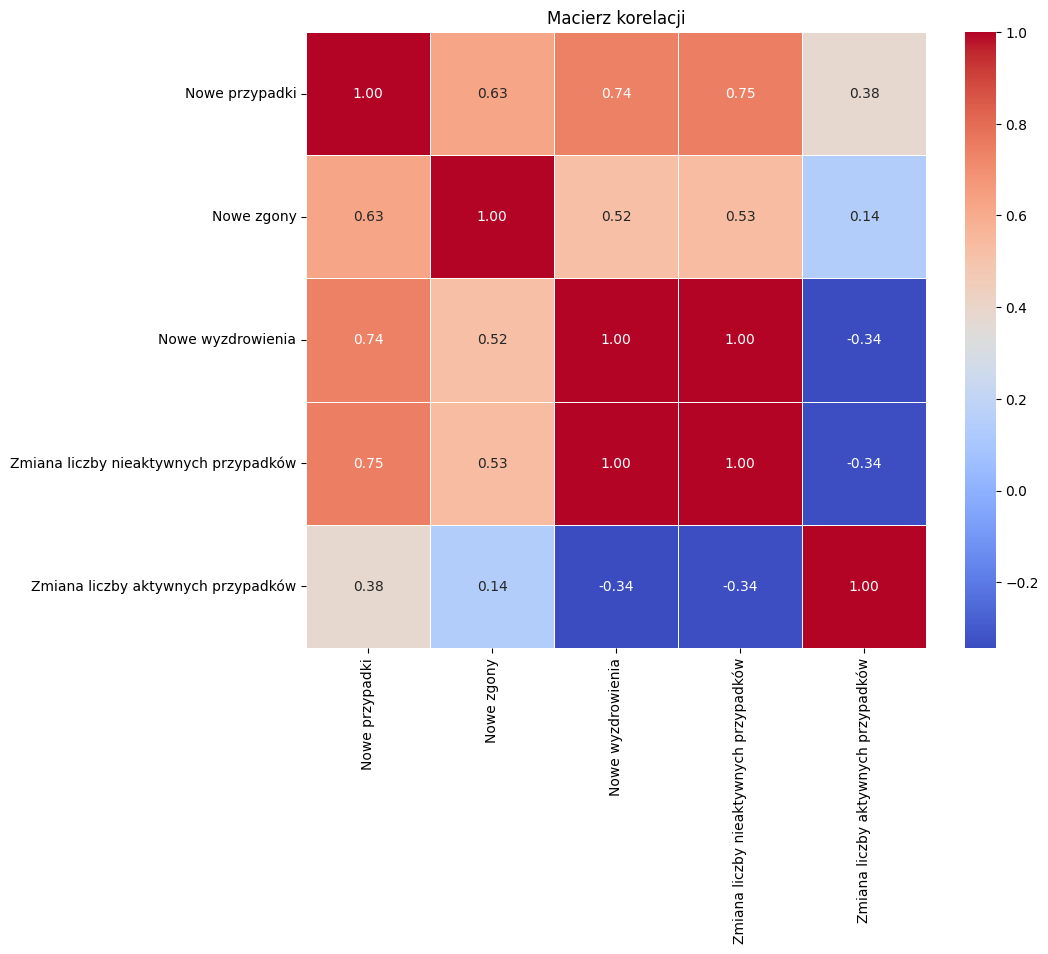

In [17]:
# Calculate the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(df.drop(columns=['Data']).corr(), annot=True, fmt=".2f", cmap="coolwarm", linewidths=.5)
plt.title('Macierz korelacji')
plt.show()

In [18]:
df.tail()

,Data,Nowe przypadki,Nowe zgony,Nowe wyzdrowienia,Zmiana liczby nieaktywnych przypadków,Zmiana liczby aktywnych przypadków
734,2022-03-07,5585,6,12049,12055,-6470
735,2022-03-08,13152,217,9990,10207,2945
736,2022-03-09,14415,234,9826,10060,4355
737,2022-03-10,13438,184,8460,8644,4794
738,2022-03-11,11637,121,8599,8720,2917


In [29]:
# Scaling the data
scaler = MinMaxScaler()
df[['Nowe przypadki', 'Zmiana liczby aktywnych przypadków', 'Zmiana liczby nieaktywnych przypadków', 'Nowe zgony', 'Nowe wyzdrowienia']] = scaler.fit_transform(df[['Nowe przypadki', 'Zmiana liczby aktywnych przypadków', 'Zmiana liczby nieaktywnych przypadków', 'Nowe zgony', 'Nowe wyzdrowienia']])

# Split the data into training and testing sets
split_ratio = 0.8
split_idx = int(len(df) * split_ratio)
train_df = df[:split_idx]
test_df = df[split_idx:]

def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length, 0]  # Predict only the "Nowe przypadki"
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 30  # Example sequence length
data = df[['Nowe przypadki', 'Zmiana liczby aktywnych przypadków', 'Zmiana liczby nieaktywnych przypadków', 'Nowe zgony', 'Nowe wyzdrowienia']].values
x_data, y_data = create_sequences(data, seq_length)

# Convert to PyTorch tensors
x_data = torch.tensor(x_data, dtype=torch.float32)
y_data = torch.tensor(y_data, dtype=torch.float32).unsqueeze(1)  # Add an extra dimension for the output

In [30]:
class TimeSeriesTransformer(nn.Module):
    def __init__(self, num_features, d_model=64, nhead=8, num_encoder_layers=3, num_decoder_layers=3, dim_feedforward=128, dropout=0.1):
        super(TimeSeriesTransformer, self).__init__()
        self.model_type = 'Transformer'
        self.embedding = nn.Linear(num_features, d_model)

        self.encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_encoder_layers)

        self.decoder_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer_decoder = nn.TransformerDecoder(self.decoder_layer, num_layers=num_decoder_layers)

        self.linear = nn.Linear(d_model, 1)  # Predict only one value
        self.dropout = nn.Dropout(p=dropout)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.linear.bias.data.zero_()
        self.linear.weight.data.uniform_(-initrange, initrange)

    def positional_encoding(self, seq_len, d_model):
        position = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe = torch.zeros(seq_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return pe.unsqueeze(1)  # Add batch dimension

    def forward(self, src, tgt):
        src = self.embedding(src)  # Apply embedding layer
        tgt = self.embedding(tgt)  # Apply embedding layer
        src = src.permute(1, 0, 2)  # Transformer expects seq_len, batch_size, num_features
        tgt = tgt.permute(1, 0, 2)

        src_pe = self.positional_encoding(src.size(0), src.size(2)).to(src.device)
        tgt_pe = self.positional_encoding(tgt.size(0), tgt.size(2)).to(tgt.device)

        src = src + src_pe
        tgt = tgt + tgt_pe

        memory = self.transformer_encoder(src)
        output = self.transformer_decoder(tgt, memory)
        output = self.linear(output)
        return output.permute(1, 0, 2)

# Model parameters
num_features = 5
d_model = 64
nhead = 8
num_encoder_layers = 3
num_decoder_layers = 3
dim_feedforward = 128
dropout = 0.1


In [31]:
# Evaluation metrics
def evaluate(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mse, mae, r2

In [37]:
model_kfold = TimeSeriesTransformer(num_features, d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, dropout)
epochs = 20
lr = 0.001

criterion = nn.MSELoss()
optimizer = optim.Adam(model_kfold.parameters(), lr=lr)

# K-Fold Cross Validation
kf = KFold(n_splits=5)

print("K-Fold Cross Validation")
for fold, (train_idx, test_idx) in enumerate(kf.split(x_data)):
    print(f"Fold {fold+1}")
    train_dataset = Subset(TensorDataset(x_data, y_data), train_idx)
    test_dataset = Subset(TensorDataset(x_data, y_data), test_idx)

    train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Training loop with test loss calculation
    for epoch in range(epochs):
        model_kfold.train()
        running_train_loss = 0.0
        for batch in train_dataloader:
            x_batch, y_batch = batch
            optimizer.zero_grad()

            # Transformer needs a target sequence as well, we'll use a shifted version of the input
            y_input = torch.zeros_like(x_batch)
            y_input[:, 1:, :] = x_batch[:, :-1, :]
            y_input[:, 0, :] = x_batch[:, 0, :]  # First element as it is

            output = model_kfold(x_batch, y_input)
            loss = criterion(output[:, -1, 0], y_batch.squeeze(-1))  # Ensure the dimensions match
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item() * x_batch.size(0)

        train_loss = running_train_loss / len(train_dataloader.dataset)

        # Calculate test loss
        model_kfold.eval()
        running_test_loss = 0.0
        y_true = []
        y_pred = []
        with torch.no_grad():
            for batch in test_dataloader:
                x_batch, y_batch = batch

                y_input = torch.zeros_like(x_batch)
                y_input[:, 1:, :] = x_batch[:, :-1, :]
                y_input[:, 0, :] = x_batch[:, 0, :]

                output = model_kfold(x_batch, y_input)
                loss = criterion(output[:, -1, 0], y_batch.squeeze())

                running_test_loss += loss.item() * x_batch.size(0)
                y_true.extend(y_batch.squeeze(-1).numpy())
                y_pred.extend(output[:, -1].numpy())

        test_loss = running_test_loss / len(test_dataloader.dataset)
        mse, mae, r2 = evaluate(np.array(y_true), np.array(y_pred))

        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, MSE: {mse:.4f}, MAE: {mae:.4f}, R^2: {r2:.4f}')


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


K-Fold Cross Validation
Fold 1
Epoch 1/20, Train Loss: 0.1122, Test Loss: 0.0130, MSE: 0.0130, MAE: 0.1139, R^2: -1885.1534
Epoch 2/20, Train Loss: 0.0429, Test Loss: 0.0030, MSE: 0.0030, MAE: 0.0544, R^2: -429.7464
Epoch 3/20, Train Loss: 0.0365, Test Loss: 0.0070, MSE: 0.0070, MAE: 0.0837, R^2: -1018.9630
Epoch 4/20, Train Loss: 0.0243, Test Loss: 0.0078, MSE: 0.0078, MAE: 0.0881, R^2: -1127.6978
Epoch 5/20, Train Loss: 0.0229, Test Loss: 0.0120, MSE: 0.0120, MAE: 0.1097, R^2: -1747.5650
Epoch 6/20, Train Loss: 0.0168, Test Loss: 0.0006, MSE: 0.0006, MAE: 0.0240, R^2: -83.7766
Epoch 7/20, Train Loss: 0.0103, Test Loss: 0.0054, MSE: 0.0054, MAE: 0.0731, R^2: -776.1775
Epoch 8/20, Train Loss: 0.0077, Test Loss: 0.0011, MSE: 0.0011, MAE: 0.0337, R^2: -165.2859
Epoch 9/20, Train Loss: 0.0068, Test Loss: 0.0005, MSE: 0.0005, MAE: 0.0217, R^2: -68.3473
Epoch 10/20, Train Loss: 0.0052, Test Loss: 0.0001, MSE: 0.0001, MAE: 0.0109, R^2: -16.9834
Epoch 11/20, Train Loss: 0.0050, Test Loss: 0.0

In [42]:
model_tseries = TimeSeriesTransformer(num_features, d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, dropout)
epochs = 20
lr = 0.001

criterion = nn.MSELoss()
optimizer = optim.Adam(model_tseries.parameters(), lr=lr)

# Time Series Split
tscv = TimeSeriesSplit(n_splits=5)

print("\nTime Series Split")
for fold, (train_idx, test_idx) in enumerate(tscv.split(x_data)):
    print(f"Fold {fold+1}")
    train_dataset = Subset(TensorDataset(x_data, y_data), train_idx)
    test_dataset = Subset(TensorDataset(x_data, y_data), test_idx)

    train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Training loop with test loss calculation
    for epoch in range(epochs):
        model_tseries.train()
        running_train_loss = 0.0
        for batch in train_dataloader:
            x_batch, y_batch = batch
            optimizer.zero_grad()

            # Transformer needs a target sequence as well, we'll use a shifted version of the input
            y_input = torch.zeros_like(x_batch)
            y_input[:, 1:, :] = x_batch[:, :-1, :]
            y_input[:, 0, :] = x_batch[:, 0, :]  # First element as it is

            output = model_tseries(x_batch, y_input)
            loss = criterion(output[:, -1, 0], y_batch.squeeze())  # Ensure the dimensions match
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item() * x_batch.size(0)

        train_loss = running_train_loss / len(train_dataloader.dataset)

        # Calculate test loss
        model_tseries.eval()
        running_test_loss = 0.0
        y_true = []
        y_pred = []
        with torch.no_grad():
            for batch in test_dataloader:
                x_batch, y_batch = batch

                y_input = torch.zeros_like(x_batch)
                y_input[:, 1:, :] = x_batch[:, :-1, :]
                y_input[:, 0, :] = x_batch[:, 0, :]

                output = model_tseries(x_batch, y_input)
                loss = criterion(output[:, -1, 0], y_batch.squeeze())

                running_test_loss += loss.item() * x_batch.size(0)
                y_true.extend(y_batch.squeeze().numpy())
                y_pred.extend(output[:, -1, 0].numpy())

        test_loss = running_test_loss / len(test_dataloader.dataset)
        mse, mae, r2 = evaluate(np.array(y_true), np.array(y_pred))

        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, MSE: {mse:.4f}, MAE: {mae:.4f}, R^2: {r2:.4f}')


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")



Time Series Split
Fold 1
Epoch 1/20, Train Loss: 0.3313, Test Loss: 0.0387, MSE: 0.0387, MAE: 0.1859, R^2: -0.6151
Epoch 2/20, Train Loss: 0.0922, Test Loss: 0.0235, MSE: 0.0235, MAE: 0.1265, R^2: 0.0188
Epoch 3/20, Train Loss: 0.0140, Test Loss: 0.1271, MSE: 0.1271, MAE: 0.3230, R^2: -4.3095
Epoch 4/20, Train Loss: 0.0357, Test Loss: 0.0412, MSE: 0.0412, MAE: 0.1347, R^2: -0.7223
Epoch 5/20, Train Loss: 0.0094, Test Loss: 0.0238, MSE: 0.0238, MAE: 0.1381, R^2: 0.0044
Epoch 6/20, Train Loss: 0.0187, Test Loss: 0.0352, MSE: 0.0352, MAE: 0.1115, R^2: -0.4718
Epoch 7/20, Train Loss: 0.0074, Test Loss: 0.0700, MSE: 0.0700, MAE: 0.2154, R^2: -1.9241
Epoch 8/20, Train Loss: 0.0105, Test Loss: 0.0436, MSE: 0.0436, MAE: 0.1411, R^2: -0.8197
Epoch 9/20, Train Loss: 0.0054, Test Loss: 0.0276, MSE: 0.0276, MAE: 0.1162, R^2: -0.1544
Epoch 10/20, Train Loss: 0.0073, Test Loss: 0.0348, MSE: 0.0348, MAE: 0.1115, R^2: -0.4512
Epoch 11/20, Train Loss: 0.0050, Test Loss: 0.0493, MSE: 0.0493, MAE: 0.159

In [44]:
model_btseries = TimeSeriesTransformer(num_features, d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, dropout)
epochs = 20
lr = 0.001

criterion = nn.MSELoss()
optimizer = optim.Adam(model_btseries.parameters(), lr=lr)

# Blocking Time Series Split
def blocking_time_series_split(data, n_splits):
    fold_size = len(data) // n_splits
    indices = np.arange(len(data))
    for i in range(n_splits):
        test_start = i * fold_size
        test_end = test_start + fold_size
        train_indices = np.concatenate([indices[:test_start], indices[test_end:]])
        test_indices = indices[test_start:test_end]
        yield train_indices, test_indices

print("\nBlocking Time Series Split")
for fold, (train_idx, test_idx) in enumerate(blocking_time_series_split(x_data, n_splits=5)):
    print(f"Fold {fold+1}")
    train_dataset = Subset(TensorDataset(x_data, y_data), train_idx)
    test_dataset = Subset(TensorDataset(x_data, y_data), test_idx)

    train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Training loop with test loss calculation
    for epoch in range(epochs):
        model_btseries.train()
        running_train_loss = 0.0
        for batch in train_dataloader:
            x_batch, y_batch = batch
            optimizer.zero_grad()

            # Transformer needs a target sequence as well, we'll use a shifted version of the input
            y_input = torch.zeros_like(x_batch)
            y_input[:, 1:, :] = x_batch[:, :-1, :]
            y_input[:, 0, :] = x_batch[:, 0, :]  # First element as it is

            output = model_btseries(x_batch, y_input)
            loss = criterion(output[:, -1, 0], y_batch.squeeze())  # Ensure the dimensions match
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item() * x_batch.size(0)

        train_loss = running_train_loss / len(train_dataloader.dataset)

        # Calculate test loss
        model_btseries.eval()
        running_test_loss = 0.0
        y_true = []
        y_pred = []
        with torch.no_grad():
            for batch in test_dataloader:
                x_batch, y_batch = batch

                y_input = torch.zeros_like(x_batch)
                y_input[:, 1:, :] = x_batch[:, :-1, :]
                y_input[:, 0, :] = x_batch[:, 0, :]

                output = model_btseries(x_batch, y_input)
                loss = criterion(output[:, -1, 0], y_batch.squeeze())

                running_test_loss += loss.item() * x_batch.size(0)
                y_true.extend(y_batch.squeeze().numpy())
                y_pred.extend(output[:, -1, 0].numpy())

        test_loss = running_test_loss / len(test_dataloader.dataset)
        mse, mae, r2 = evaluate(np.array(y_true), np.array(y_pred))

        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, MSE: {mse:.4f}, MAE: {mae:.4f}, R^2: {r2:.4f}')

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")



Blocking Time Series Split
Fold 1
Epoch 1/20, Train Loss: 0.1536, Test Loss: 0.0834, MSE: 0.0834, MAE: 0.2889, R^2: -13029.9372
Epoch 2/20, Train Loss: 0.0457, Test Loss: 0.0430, MSE: 0.0430, MAE: 0.2074, R^2: -6713.7000
Epoch 3/20, Train Loss: 0.0370, Test Loss: 0.0160, MSE: 0.0160, MAE: 0.1265, R^2: -2500.6139
Epoch 4/20, Train Loss: 0.0318, Test Loss: 0.0049, MSE: 0.0049, MAE: 0.0703, R^2: -771.2797
Epoch 5/20, Train Loss: 0.0244, Test Loss: 0.0007, MSE: 0.0007, MAE: 0.0266, R^2: -110.7454
Epoch 6/20, Train Loss: 0.0166, Test Loss: 0.0001, MSE: 0.0001, MAE: 0.0071, R^2: -7.7467
Epoch 7/20, Train Loss: 0.0106, Test Loss: 0.0001, MSE: 0.0001, MAE: 0.0096, R^2: -13.9955
Epoch 8/20, Train Loss: 0.0104, Test Loss: 0.0012, MSE: 0.0012, MAE: 0.0347, R^2: -187.9895
Epoch 9/20, Train Loss: 0.0075, Test Loss: 0.0001, MSE: 0.0001, MAE: 0.0093, R^2: -13.1738
Epoch 10/20, Train Loss: 0.0055, Test Loss: 0.0000, MSE: 0.0000, MAE: 0.0051, R^2: -3.6826
Epoch 11/20, Train Loss: 0.0050, Test Loss: 0.

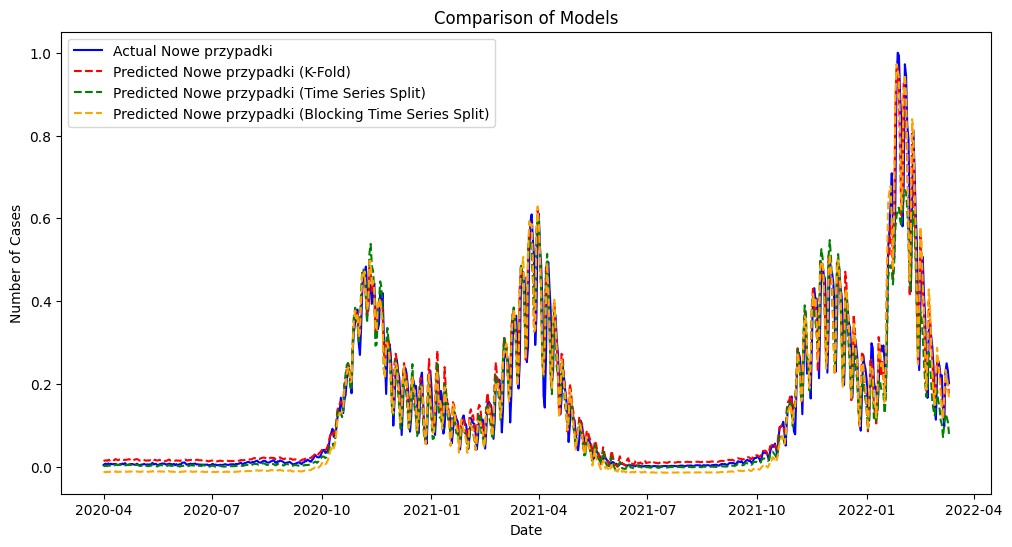

In [47]:
# Create sequences for the entire dataset for visualization purposes
def create_sequences_for_prediction(data, seq_length):
    xs = []
    for i in range(len(data) - seq_length + 1):
        x = data[i:i+seq_length]
        xs.append(x)
    return np.array(xs)

data = df[['Nowe przypadki', 'Zmiana liczby aktywnych przypadków', 'Zmiana liczby nieaktywnych przypadków', 'Nowe zgony', 'Nowe wyzdrowienia']].values
x_all = create_sequences_for_prediction(data, seq_length)

# Convert to PyTorch tensors
x_all = torch.tensor(x_all, dtype=torch.float32)

def generate_predictions(model, x_all):
    model.eval()
    predictions_full = []
    with torch.no_grad():
        for i in range(len(x_all)):
            x_input = x_all[i:i+1]  # Get one sequence at a time
            y_input = torch.zeros_like(x_input)
            y_input[:, 1:, :] = x_input[:, :-1, :]
            y_input[:, 0, :] = x_input[:, 0, :]

            output = model(x_input, y_input)
            predictions_full.append(output[:, -1, 0].numpy())  # Extract the prediction for 'Nowe przypadki'

    # Convert predictions to numpy array
    predictions_full = np.concatenate(predictions_full)

    # Rescale the predictions back to the original scale
    predictions_rescaled = scaler.inverse_transform(np.concatenate((predictions_full.reshape(-1, 1), np.zeros((predictions_full.shape[0], 4))), axis=1))[:, 0]
    return predictions_rescaled

# Generate predictions for each model
predictions_kfold = generate_predictions(model_kfold, x_all)
predictions_tseries = generate_predictions(model_tseries, x_all)
predictions_btseries = generate_predictions(model_btseries, x_all)

# Rescale the actual values back to the original scale
y_rescaled = scaler.inverse_transform(np.concatenate((data[seq_length-1:, 0].reshape(-1, 1), np.zeros((data[seq_length-1:].shape[0], 4))), axis=1))[:, 0]

# Plot the actual and predicted values for each model
plt.figure(figsize=(12, 6))
plt.plot(df['Data'][seq_length-1:], y_rescaled, label='Actual Nowe przypadki', color='blue')
plt.plot(df['Data'][seq_length-1:], predictions_kfold, label='Predicted Nowe przypadki (K-Fold)', color='red', linestyle='dashed')
plt.plot(df['Data'][seq_length-1:], predictions_tseries, label='Predicted Nowe przypadki (Time Series Split)', color='green', linestyle='dashed')
plt.plot(df['Data'][seq_length-1:], predictions_btseries, label='Predicted Nowe przypadki (Blocking Time Series Split)', color='orange', linestyle='dashed')

plt.title('Comparison of Models')
plt.xlabel('Date')
plt.ylabel('Number of Cases')
plt.legend()
plt.show()